# Chapter 20 Numerical Integration of Function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### 반복 사다리꼴 규칙
$J_k$를 구간 $(a, b)$를 $2^k$ 구간으로 나누어 적분한 결과라 하면 

$$k = 0, \qquad h_0 = b-a, \quad J_0 = \frac{h}{2} (f(a) + f(b))$$
$$k = 1, \qquad h_1 = \frac{h_0}{2}, \quad J_1 = \frac{J_0}{2} + h_1 f(a+h_1)$$
$$k = 2, \qquad h_2 = \frac{h_1}{2}, \quad J_2 = \frac{J_1}{2} + h_2 [f(a+h_2) + f(a+3h_2)]$$

즉 다음 식이 성립한다. 

$$ J_k  = \frac{J_{k-1}}{2} + h_k \sum f(x_{new})$$

In [3]:
def trapz_iter(fun, a, b, tol=1e-3, kmax=10):
    h = (b - a)
    Jold = h/2*(fun(a) + fun(b))
    for k in range(kmax):
        h = h/2        
        x = np.arange(a + h, b - h/2, 2*h)
        f = fun(x)
        J = Jold/2 + h*np.sum(f)
        if abs((J-Jold)/J) < tol:
            return J, k
        Jold = J
    print('too many iteration')

### Example
$$\int_0^{\pi} e^{-x^2} \sin(x) dx$$

In [4]:
from scipy.integrate import quad

def fun(x):
    return np.sin(x)*np.exp(-x**2)

a, b = 0, np.pi
res1 = quad(fun, a, b)
print(res1)
res2 = trapz_iter(fun, a, b)
print(res2)

(0.42443751077246467, 2.2123286753150863e-09)
(0.4243873052464412, 6)


위 결과를 보면 구간을 7회에 결쳐 반분, 즉 $2^7$ 개의 구간으로 나누어 계산한 결과가 순차적으로 표시되어 있고 최종 결과는 **quad**와 유사하다. 즉 원하는 정확도를 얻기 위해서는 구간을 많은 수로 나누어야 하는데 보다 개선된 방법이 Romberg 적분이다. 

### Romberg Integration
Romberg 적분은 반복 사다리꼴 공식과 Richardson extrapolation을 결합한 것이다. 그 결과만 나타내면

$$ R_{i,j} = \frac{4^{j-1} R_{i,j-1} - R_{i-1,j-1}}{4^{j-1}-1} $$

In [5]:
def romberg(fun, a, b, kmax=10, tol=1e-3):
    R = np.zeros((kmax, kmax))
    h = b - a
    R[0,0] = h/2*(fun(a) + fun(b))
    for i in range(1, kmax):
        h /= 2
        x = np.arange(a + h, b - h/2, 2*h)
        f = fun(x)
        R[i,0] = R[i-1,0]/2 + h*np.sum(f)
        for j in range(1, i+1):
            c = 4**j
            R[i,j] = (c*R[i,j-1] - R[i-1,j-1])/(c - 1)        
        if np.abs(R[i,i] - R[i-1,i-1]) < tol*np.max([1, np.abs(R[i,i])]):
            return R[i,i], R[:i+1, :i+1]
    return None

In [6]:
a, b = 0, np.pi
res1 = quad(fun, a, b)
print(res1[0])
res2 = trapz_iter(fun, a, b)
print(res2)
res3 = romberg(fun, a, b)
print(res3[0])
print(np.round(res3[1],4))

0.42443751077246467
(0.4243873052464412, 6)
0.4244289079516322
[[0.     0.     0.     0.     0.    ]
 [0.1332 0.1776 0.     0.     0.    ]
 [0.3685 0.4469 0.4648 0.     0.    ]
 [0.4113 0.4256 0.4242 0.4236 0.    ]
 [0.4212 0.4245 0.4244 0.4244 0.4244]]


### Planetary Orbit
Kepler' law

- The orbit of a planet is an ellipse with the Sun at one of the two foci.
- A line segment joining a planet and the Sun sweeps out equal areas during equal intervals of time.
- The square of the orbital period of a planet is directly proportional to the cube of the semi-major axis of its orbit.

$$ 2 \pi t = P (\theta - e \sin(\theta)$$
$$x = a \cos(\theta), \quad y = b \sin(\theta), \quad b^2 = a^2 (1- e^2)$$

arc length

$$L = \int_{\theta_1}^{\theta_2} \sqrt{(x')^2 +(y')^2} d \theta $$

In [7]:
def secant(func, x1, x2, tol=1e-6):    
    f1, f2 = func(x1), func(x2)
    k = 0
    while 1:
        k += 1
        x3 = x2 - f2*(x1 - x2)/(f1 - f2)
        f3 = func(x3)
        if np.abs(x1 - x3) < tol*np.max([1, np.abs(x3)]):
            return x3, k
        x1, f1 = x2, f2
        x2, f2 = x3, f3

  10.00      1.07    0.8857
  20.00      1.75    0.6733
  30.00      2.27    0.4968
  40.00      2.72    0.3829
  50.00      3.14    0.3243
  60.00      3.56    0.3243
  70.00      4.01    0.3829
  80.00      4.53    0.4968
  90.00      5.22    0.6733
 100.00      6.28    0.8857
5.5258557104110295


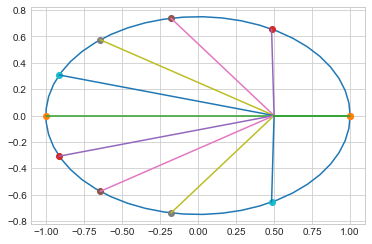

In [8]:
P, e, a = 100, 0.5, 1
# b = a*np.sqrt(1-e*e)
b = 3/4
r = np.linspace(0, 2*np.pi)
plt.plot(a*np.cos(r), b*np.sin(r))

fun = lambda r, t: 2*np.pi*t - P*(r - e*np.sin(r))

r = []
t = np.linspace(0, P, 11)
for t1 in t:
    r1, k = secant(lambda r: fun(r, t1), 1, 2)
    x = a*np.cos(r1)
    y = b*np.sin(r1)
    
    plt.plot(x, y, 'o')
    plt.plot([e*a, x],[0, y])
              
    r.append(r1)

fun = lambda r: np.sqrt((a*np.sin(r))**2 + (b*np.cos(r))**2)    
s =[]
for i in range(1, len(r)):
    s1, k = romberg(fun, r[i-1], r[i])
    s.append(s1)
    
for i in range(1, len(r)):
    print("{:>7.2f}{:10.2f}{:10.4f}".format(t[i], r[i], s[i-1]))
    
print(np.sum(s))    
plt.show()

### Gauss Quadrature

In [9]:
def gauss_quad1(fun, a, b):
    p = np.array([-0.7745966692, 0.0000000000, 0.7745966692])
    w = np.array([ 0.5555555556, 0.8888888889, 0.5555555556])
    x = (b+a)/2 + (b-a)/2*p
    f = fun(x)
    res = np.dot(w,f)*(b-a)/2.
    return res

In [10]:
from scipy.special import erf
def fun(x): return 2/np.sqrt(np.pi)*np.exp(-x**2)
a, b = 0, 1
J = gauss_quad1(fun, a, b)
print(J - erf(1))

-1.0774420349024538e-05


In [11]:
from scipy.special import roots_legendre
print("{0:>5s}{1:>20s}{2:>20s}".format('n', 'node','weight'))  
for n in range(2, 7):
    print('')
    node, weight = roots_legendre(n)
    for i in range(n):
        if i == 0:
            print("{0:5d}{1:20.10f}{2:20.10f}"
                  .format(n, node[i], weight[i]))
        else:
            print("{0:5s}{1:20.10f}{2:20.10f}"
                  .format("", node[i], weight[i]))        

    n                node              weight

    2       -0.5773502692        1.0000000000
             0.5773502692        1.0000000000

    3       -0.7745966692        0.5555555556
             0.0000000000        0.8888888889
             0.7745966692        0.5555555556

    4       -0.8611363116        0.3478548451
            -0.3399810436        0.6521451549
             0.3399810436        0.6521451549
             0.8611363116        0.3478548451

    5       -0.9061798459        0.2369268851
            -0.5384693101        0.4786286705
             0.0000000000        0.5688888889
             0.5384693101        0.4786286705
             0.9061798459        0.2369268851

    6       -0.9324695142        0.1713244924
            -0.6612093865        0.3607615730
            -0.2386191861        0.4679139346
             0.2386191861        0.4679139346
             0.6612093865        0.3607615730
             0.9324695142        0.1713244924


### Gauss quadrature using Quadrilateral Element

In [12]:
def gauss_quad2(fun, xd, yd, n=3):
    node, weight = roots_legendre(n)
    X = np.vstack([xd, yd]).T
    res = 0.0
    for i in range(n):
        s, ws = node[i], weight[i]
        for j in range(n):
            t, wt = node[j], weight[j]
            N = np.array(
                [(1-s)*(1-t), (1+s)*(1-t),
                 (1+s)*(1+t), (1-s)*(1+t)])/4.0
            
            x, y = np.matmul(N, X)
            f = fun(x, y)
            
            dN = np.array(
                [[-1+t,  1-t, 1+t, -1-t],
                 [-1+s, -1-s, 1+s,  1-s]])/4.0
            J = np.matmul(dN, X)
            dJ = J[0,0]*J[1,1] - J[0,1]*J[1,0]
            
            res = res + ws*wt*f*dJ
    return res

In [13]:
def fun(x,y): return x**2 + y
xd = np.array([0, 2, 2, 0])
yd = np.array([0, 0, 3, 2])

res = gauss_quad2(fun, xd, yd)
res

13.666666666666663

### Adaptive Quadrature

In [14]:
def quad_adapt(fun, a, b, tol=1e-3):
    
    def simp(f): return (f[0] + 4*f[1] + f[2])/3

    def recur(fun, x, f, W, tol):        
        h = (x[1] - x[0])/2
        x = np.array([x[0], x[0]+h,    x[1], x[1]+h,    x[2]])
        f = np.array([f[0], fun(x[1]), f[1], fun(x[3]), f[2]])
        plt.plot(x, f, '.')
        L = simp(f[:3])*h
        R = simp(f[2:])*h
        err = (L + R - W)/15
        if np.abs(err) < tol: return L + R + err
        L = recur(fun, x[:3],  f[:3],  L, tol/2)
        R = recur(fun, x[-3:], f[-3:], R, tol/2)
        return L + R
    """ main """    
    h = (b - a)/2
    x = np.array([a, a+h, b])
    f = fun(x)
    W = simp(f)*h
    return recur(fun, x, f, W, tol/2)

1.2594704354494726

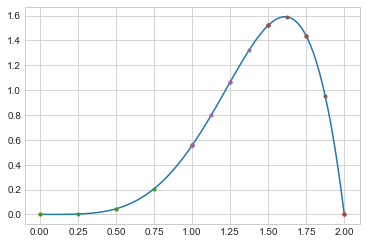

In [15]:
def fun(x): return 1/4*np.pi*x**4*np.cos(1/4*np.pi*x)
a, b = 0, 2

x = np.linspace(a, b, 100)
plt.plot(x, fun(x))

J = quad_adapt(fun, a, b, tol=1e-3)
plt.grid('on');
J

## Gauss-Kronrod quadrature

In [16]:
K = np.array([
    [0.991455371120813, 0.022935322010529, 0.               ],
    [0.949107912342759, 0.063092092629979, 0.129484966168870],
    [0.864864423359769, 0.104790010322250, 0.               ],
    [0.741531185599394, 0.140653259715525, 0.279705391489277],
    [0.586087235467691, 0.169004726639267, 0.               ],
    [0.405845151377397, 0.190350578064785, 0.381830050505119],
    [0.207784955007898, 0.204432940075298, 0.               ],
    [0.000000000000000, 0.209482141084728, 0.417959183673469]])

NODE = np.r_[-K[:-1, 0], K[-1::-1, 0]]
KW   = np.r_[ K[:-1, 1], K[-1::-1, 1]]
GW   = np.r_[ K[:-1, 2], K[-1::-1, 2]][1::2]


def g7k15(fun, a, b):
    """ (G7, K15) Gauss–Kronrod quadrature """
    c1, c2 = (b + a)/2, (b - a)/2
    x = c1 + c2*NODE
    f = fun(x)
    q1 = np.dot(KW, f)*c2
    q2 = np.dot(GW, f[1:-1:2])*c2
    return q1, np.abs(q1 - q2)

def quad_agk(fun, a, b, tol):
    """ adaptive Gauss–Kronrod quadrature (G7, K15) """
    # print(a, b)
    Q, err = g7k15(fun, a, b)
    if err > tol:
        m = (a + b)/2
        Q = quad_agk(fun, a, m, tol/2) + quad_agk(fun, m, b, tol/2)
    return Q


In [17]:
I = quad_agk(np.sin, 0, 5*np.pi, 1e-9)
print(I)

1.9999999999999956
